In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly import subplots
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

from copy import deepcopy

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-global-dataset/worldometer_coronavirus_daily_data.csv
/kaggle/input/covid19-global-dataset/worldometer_coronavirus_summary_data.csv
/kaggle/input/d/gpreda/covid-world-vaccination-progress/country_vaccinations_by_manufacturer.csv
/kaggle/input/d/gpreda/covid-world-vaccination-progress/country_vaccinations.csv
/kaggle/input/countries-iso-codes-continent-flags-url/countries_continents_codes_flags_url.csv
/kaggle/input/country-mapping-iso-continent-region/continents2.csv


In [3]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_grey2 = "#696969"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [4]:
df = pd.read_csv('/kaggle/input/d/gpreda/covid-world-vaccination-progress/country_vaccinations.csv')
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17607 entries, 0 to 17606
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              17607 non-null  object 
 1   iso_code                             17607 non-null  object 
 2   date                                 17607 non-null  object 
 3   total_vaccinations                   10251 non-null  float64
 4   people_vaccinated                    9526 non-null   float64
 5   people_fully_vaccinated              7185 non-null   float64
 6   daily_vaccinations_raw               8568 non-null   float64
 7   daily_vaccinations                   17391 non-null  float64
 8   total_vaccinations_per_hundred       10251 non-null  float64
 9   people_vaccinated_per_hundred        9526 non-null   float64
 10  people_fully_vaccinated_per_hundred  7185 non-null   float64
 11  daily_vaccinations_per_milli

In [8]:
df.loc[df['iso_code'].isnull(), 'country'].value_counts()

Series([], Name: country, dtype: int64)

We can fix this easyly with imputation ('GBR') 

In [9]:
df['iso_code'] = df['iso_code'].fillna('GBR')

### Columns to drop

As we can see, 'daily_vaccinations_raw' has a cleaned variable 'daily_vaccinations' with less missing values, so we can now drop 'daily_vaccinations_raw'

In [10]:
df = df.drop('daily_vaccinations_raw', axis=1)

### Lets transform date column

In [11]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date', ascending=True)

df['date'] = df['date'].dt.strftime('%Y-%m-%d')

In [12]:
unique_dates = df['date'].unique()

As we can see, not all of the ISO_CODEs has all the dates. So we are going to create a row for those dates with missing values.

In [13]:
original_df = df.copy()

In [14]:
for iso_code in df['iso_code'].unique():
    for inc_date in unique_dates:
        if df.loc[df['iso_code'] == iso_code, 'date'].str.contains(inc_date).any():
            continue
        else:
            df.loc[len(df)] = [None, iso_code, inc_date] + 11 * [None]

In [15]:
df.shape

(34393, 14)

Now re-order the dataframe based on '**date**' so we can plot correctly later

In [16]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date', ascending=True)

df['date'] = df['date'].dt.strftime('%m-%d-%Y')

df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
12028,Norway,NOR,12-02-2020,1.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...
27267,None,GNQ,12-02-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
22548,None,MKD,12-02-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
18443,None,LUX,12-02-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
18473,None,MCO,12-02-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None


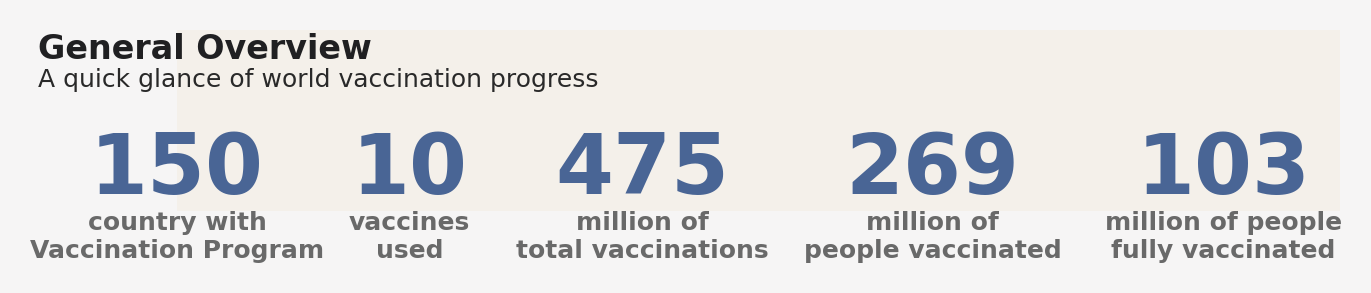

In [17]:
# I will adapt this to Plotly in future versions
plt.rcParams['figure.dpi'] = 300

fig = plt.figure(figsize=(5, 0.8), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)

background_color = "#f6f5f5"

ax0 = fig.add_subplot(gs[0, 0])

ax0.set_facecolor(primary_bgcolor)
for s in ["top","right", 'left', 'bottom']:
    ax0.spines[s].set_visible(False)
ax0.set_xticks([])
ax0.set_yticks([])

ax0.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0.text(-0.12, 0.8, 'General Overview', color=primary_black, fontsize=8, ha='left', weight='bold', va='bottom')
ax0.text(-0.12, 0.79, 'A quick glance of world vaccination progress', color='#292929', fontsize=6, ha='left', va='top')

ax0.text(0, 0, '150', color=primary_blue, fontsize=20, ha='center', weight='bold', va='bottom')
ax0.text(0, 0, 'country with\nVaccination Program', color=primary_grey2, fontsize=6, ha='center', va='top', weight='bold')

ax0.text(0.2, 0, '10', color=primary_blue, fontsize=20, ha='center', weight='bold', va='bottom')
ax0.text(0.2, 0, 'vaccines\nused', color=primary_grey2, fontsize=6, ha='center', va='top', weight='bold')

ax0.text(0.4, 0, '475', color=primary_blue, fontsize=20, ha='center', weight='bold', va='bottom')
ax0.text(0.4, 0, 'million of\ntotal vaccinations', color=primary_grey2, fontsize=6, ha='center', va='top', weight='bold')

ax0.text(0.65, 0, '269', color=primary_blue, fontsize=20, ha='center', weight='bold', va='bottom')
ax0.text(0.65, 0, 'million of\npeople vaccinated', color=primary_grey2, fontsize=6, ha='center', va='top', weight='bold')

ax0.text(0.9, 0, '103', color=primary_blue, fontsize=20, ha='center', weight='bold', va='bottom')
ax0.text(0.9, 0, 'million of people\nfully vaccinated', color=primary_grey2, fontsize=6, ha='center', va='top', weight='bold')

plt.show()

In [18]:
tdf = df.copy()


for iso_code in tdf['iso_code'].unique():
    tdf.loc[tdf['iso_code'] == iso_code, :] = tdf.loc[tdf['iso_code'] == iso_code, :].fillna(method='ffill').fillna(0)


In [19]:
fig = px.choropleth(
    tdf,                            # Input Dataframe
    locations="iso_code",           # identify country code column
    color="total_vaccinations",                     # identify representing column
    hover_name="country",              # identify hover name
    animation_frame="date",
    #category_orders={"frame": list(sorted(tdf['date'].unique()))},            # identify date column
    color_continuous_scale= 'viridis',
    projection="natural earth",        # select projection
    range_color=[0,5000000],
    title='<span style="font-size:36px; font-family:Times New Roman">Number of vaccinations per country</span>',
)             # select range of dataset     
fig.show() 

In [20]:
fig = px.choropleth(
    tdf,                            # Input Dataframe
    locations="iso_code",           # identify country code column
    color="daily_vaccinations",                     # identify representing column
    hover_name="country",              # identify hover name
    animation_frame="date",
    #category_orders={"frame": list(sorted(tdf['date'].unique()))},            # identify date column
    color_continuous_scale= 'viridis',
    projection="natural earth",        # select projection
    range_color=[0,1000000],
    title='<span style="font-size:36px; font-family:Times New Roman">Number of daily vaccinations</span>',
)             # select range of dataset     
fig.show() 

<a id='2.2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2.2 Top vaccines Laboratories</p>

In [21]:
tdf = df.copy()
tdf = tdf.dropna(subset=['vaccines'])

vac_df = tdf.groupby(['iso_code','vaccines']).max().reset_index()
vac_df['vaccines_split'] = vac_df['vaccines'].apply(lambda x: [w.strip() for w in x.split(',')])
vac_df.head()

,iso_code,vaccines,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,source_name,source_website,vaccines_split
0,ABW,Pfizer/BioNTech,Aruba,05-13-2021,85441.0,56932.0,28509.0,2493.0,80.03,53.32,26.70,23350.0,Government of Aruba,https://www.government.aw,[Pfizer/BioNTech]
1,AFG,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Afghanistan,05-11-2021,504502.0,448878.0,55624.0,13921.0,1.30,1.15,0.14,358.0,World Health Organization,https://covid19.who.int/,"[Oxford/AstraZeneca, Pfizer/BioNTech, Sinophar..."
2,AGO,Oxford/AstraZeneca,Angola,05-12-2021,626572.0,586377.0,40195.0,18751.0,1.91,1.78,0.12,571.0,World Health Organization,https://covid19.who.int/,[Oxford/AstraZeneca]
3,AIA,Oxford/AstraZeneca,Anguilla,04-22-2021,6898.0,6115.0,783.0,331.0,45.98,40.76,5.22,22064.0,Ministry of Health,https://www.travelpulse.com/news/impacting-tra...,[Oxford/AstraZeneca]
4,ALB,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...",Albania,05-12-2021,632676.0,444755.0,187921.0,17565.0,21.98,15.45,6.53,6104.0,Ministry of Health,https://shendetesia.gov.al/vaksinimi-anticovid...,"[Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac,..."


In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

one_hot = MultiLabelBinarizer()

vac_data = one_hot.fit_transform(vac_df['vaccines_split'])
vac_names = one_hot.classes_
vac_countries = vac_df['country']

final_vac_df = pd.DataFrame(data=vac_data, columns=vac_names, index=vac_countries)
final_vac_df = final_vac_df.reset_index()
final_vac_df.head()

,country,Abdala,CanSino,Covaxin,EpiVacCorona,Johnson&Johnson,Moderna,Oxford/AstraZeneca,Pfizer/BioNTech,Sinopharm/Beijing,Sinopharm/Wuhan,Sinovac,Sputnik V
0,Aruba,0,0,0,0,0,0,0,1,0,0,0,0
1,Afghanistan,0,0,0,0,0,0,1,1,1,0,0,0
2,Angola,0,0,0,0,0,0,1,0,0,0,0,0
3,Anguilla,0,0,0,0,0,0,1,0,0,0,0,0
4,Albania,0,0,0,0,0,0,1,1,0,0,1,1


In [23]:
ncountrys_vac = final_vac_df[vac_names].sum(axis=0).sort_values()
colors =  [primary_grey]*4 + [primary_blue2]*4 + [primary_blue]*2 


fig = go.Figure(go.Bar(
    x = ncountrys_vac.values,
    y = ncountrys_vac.index,
    orientation = 'h',
))
fig.update_traces(
    marker_color=colors,
    marker_line_color=primary_black,
    marker_line_width=1.5, 
    opacity=0.6,
)
fig.update_layout(
    title='<span style="font-size:36px; font-family:Times New Roman">Vaccines laboratory distribution by countries</span>',
)

'''
fig.add_layout_image(
    dict(
        source='https://upload.wikimedia.org/wikipedia/commons/9/9a/Flag_of_Afghanistan.svg',
        x=35, y="Moderna",
        sizex=2.5, sizey=0.75,
        xanchor="left", yanchor="middle",
        sizing='stretch',
        xref='x',
        yref="y",
    )
)
'''

fig.show()

<a id='2.3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2.3 Distribution of vaccinatios by country</p>

In [24]:
regions_df = pd.read_csv('/kaggle/input/countries-iso-codes-continent-flags-url/countries_continents_codes_flags_url.csv')
full_df = df.merge(regions_df[['alpha-3', 'region', 'image_url']], left_on='iso_code', right_on='alpha-3')

world_summary_df = pd.read_csv('/kaggle/input/covid19-global-dataset/worldometer_coronavirus_summary_data.csv')
full_df = full_df.merge(world_summary_df, on='country', how='left')
full_df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,...,total_confirmed,total_deaths,total_recovered,active_cases,serious_or_critical,total_cases_per_1m_population,total_deaths_per_1m_population,total_tests,total_tests_per_1m_population,population
0,Norway,NOR,12-02-2020,1.0,1.0,NaN,NaN,0.0,0.0,NaN,...,119500.0,774.0,88952.0,29774.0,21.0,21893.0,142.0,5423294.0,993583.0,5458320.0
1,Norway,NOR,12-03-2020,1.0,1.0,NaN,0.0,0.0,0.0,NaN,...,119500.0,774.0,88952.0,29774.0,21.0,21893.0,142.0,5423294.0,993583.0,5458320.0
2,Norway,NOR,12-04-2020,2.0,2.0,NaN,0.0,0.0,0.0,NaN,...,119500.0,774.0,88952.0,29774.0,21.0,21893.0,142.0,5423294.0,993583.0,5458320.0
3,Norway,NOR,12-05-2020,2.0,2.0,NaN,0.0,0.0,0.0,NaN,...,119500.0,774.0,88952.0,29774.0,21.0,21893.0,142.0,5423294.0,993583.0,5458320.0
4,Norway,NOR,12-06-2020,2.0,2.0,NaN,0.0,0.0,0.0,NaN,...,119500.0,774.0,88952.0,29774.0,21.0,21893.0,142.0,5423294.0,993583.0,5458320.0


In [25]:
full_df['total_deaths_ratio'] = full_df['total_deaths'] / full_df['population']
full_df['total_confirmed_ratio'] = full_df['total_confirmed'] / full_df['population']
full_df['total_recovered_ratio'] = full_df['total_recovered'] / full_df['population']

world_summary_df['total_deaths_ratio'] = world_summary_df['total_deaths'] / world_summary_df['population']
world_summary_df['total_confirmed_ratio'] = world_summary_df['total_confirmed'] / world_summary_df['population']
world_summary_df['total_recovered_ratio'] = world_summary_df['total_recovered'] / world_summary_df['population']

In [26]:
def get_multi_line_title(title:str, subtitle:str):
    return f'<span style="font-size:32px; font-family:Times New Roman">{title}<br><sub>{subtitle}</sub></span>'

# Thanks to 
def plotly_bar_chart(data: pd.DataFrame, xcolumn: str, ycolumn:str, title:str, colors:str, ylabel="Count", n=None):
    hovertemplate ='<br><b>%{x}</b>'+f'<br><b>{ylabel}: </b>'+'%{y}<br><extra></extra>'    
    data = data.sort_values(ycolumn, ascending=False).dropna(subset=[ycolumn])        
    
    if n is not None: 
        data = data.iloc[:n]
    else:
        n = ""
    fig = go.Figure(go.Bar(
        hoverinfo='skip',
        x=data[xcolumn], 
        y=data[ycolumn], 
        hovertemplate = hovertemplate,
        marker=dict(
            color = data[ycolumn],
            colorscale=colors,
        ),
    ))
    
    max_y_val = data[ycolumn].max()
    for country, flag_url, ppl_vac in zip(data[xcolumn], data['image_url'], data[ycolumn]):
        if not flag_url or not isinstance(flag_url, str):
            continue
        fig.add_layout_image(
            dict(
                source=flag_url,
                x=country, 
                y=ppl_vac + 0.05 * max_y_val,
                sizex=0.5, 
                sizey=0.08 * max_y_val,
                xanchor="center", yanchor="bottom",
                sizing='stretch',
                xref='x',
                yref="y",
            ),
        )
    
    fig.update_yaxes(range=[0, max_y_val + 0.15*max_y_val])
    
    fig.update_layout(
        title=title,
        xaxis_title=f"Top {n} {xcolumn.title()}",
        yaxis_title=ylabel,
        plot_bgcolor='rgba(0,0,0,0)',
        hovermode="x",
    )
    
    fig.show()

In [27]:
tdf = full_df.sort_values('people_vaccinated', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)
tdf.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,...,active_cases,serious_or_critical,total_cases_per_1m_population,total_deaths_per_1m_population,total_tests,total_tests_per_1m_population,population,total_deaths_ratio,total_confirmed_ratio,total_recovered_ratio
0,United States,USA,05-13-2021,266596486.0,154624231.0,118987308.0,2088962.0,79.71,46.23,35.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,India,IND,05-13-2021,178361846.0,139087590.0,39274256.0,2251178.0,12.92,10.08,2.85,...,3353733.0,8944.0,18126.0,200.0,318292881.0,228681.0,1.391864e+09,0.000200,0.018126,0.015516
2,United Kingdom,GBR,05-12-2021,54797640.0,35906671.0,18890969.0,510250.0,80.72,52.89,27.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Brazil,BRA,05-13-2021,50308106.0,34092728.0,16215378.0,537959.0,23.67,16.04,7.63,...,1071811.0,8318.0,73223.0,2043.0,47073060.0,220090.0,2.138813e+08,0.002043,0.073223,0.066170
4,Germany,DEU,05-13-2021,38646171.0,29891651.0,8822370.0,710076.0,46.13,35.68,10.53,...,220722.0,4123.0,42946.0,1034.0,58093759.0,691439.0,8.401860e+07,0.001034,0.042946,0.039285


In [28]:
title = get_multi_line_title("People Vaccinated", "Individuals who received the first dose of the vaccine")
plotly_bar_chart(tdf, 'country', "people_vaccinated", title, "Blugrn", n=10)

In [29]:
tdf = full_df.copy()
tdf = tdf.sort_values('people_vaccinated_per_hundred', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)

In [30]:
title = get_multi_line_title("People Vaccinated per Hundred", "Percent of individuals who received the first dose of the vaccine")
plotly_bar_chart(tdf, 'country', "people_vaccinated_per_hundred", title, "Blugrn", n=10, ylabel='Percent')

In [31]:
tdf = full_df.copy()
tdf = tdf.sort_values('total_vaccinations', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)

In [32]:
title = get_multi_line_title("Total Vaccinations", "Total number of vaccinations by country")
plotly_bar_chart(tdf, 'country', "total_vaccinations", title, "Purp", n=10)

In [33]:
tdf = full_df.copy()
tdf = tdf.sort_values('total_vaccinations_per_hundred', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)

In [34]:
title = get_multi_line_title("Total Vaccinations per Hundred", "Ratio between vaccination number and total population up to the date in the country;")
plotly_bar_chart(tdf, 'country', "total_vaccinations_per_hundred", title, "Purp", n=10)

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data visualization 📊 by Continent</p>

In this case, I think that percent of people vaccinated per hundred is the most representative value so I will only plot this values.

In [35]:
regions_df = pd.read_csv('/kaggle/input/countries-iso-codes-continent-flags-url/countries_continents_codes_flags_url.csv')

regions_df.head()

,country,images_file,image_url,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,Flag_of_Afghanistan.svg,https://upload.wikimedia.org/wikipedia/commons...,AF,AFG,4.0,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Albania,Flag_of_Albania.svg,https://upload.wikimedia.org/wikipedia/commons...,AL,ALB,8.0,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
2,Algeria,Flag_of_Algeria.svg,https://upload.wikimedia.org/wikipedia/commons...,DZ,DZA,12.0,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
3,Andorra,Flag_of_Andorra.svg,https://upload.wikimedia.org/wikipedia/commons...,AD,AND,20.0,ISO 3166-2:AD,Europe,Southern Europe,NaN,150.0,39.0,NaN
4,Angola,Flag_of_Angola.svg,https://upload.wikimedia.org/wikipedia/commons...,AO,AGO,24.0,ISO 3166-2:AO,Africa,Sub-Saharan Africa,Middle Africa,2.0,202.0,17.0


In [36]:
tdf = df.merge(regions_df[['alpha-3', 'region', 'image_url']], left_on='iso_code', right_on='alpha-3')
tdf.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,alpha-3,region,image_url
0,Norway,NOR,12-02-2020,1.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
1,Norway,NOR,12-03-2020,1.0,1.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
2,Norway,NOR,12-04-2020,2.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
3,Norway,NOR,12-05-2020,2.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
4,Norway,NOR,12-06-2020,2.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...


In [37]:
continents_tdf = tdf.sort_values('people_vaccinated_per_hundred', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)

continents_tdf.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,alpha-3,region,image_url
0,Gibraltar,GIB,05-07-2021,74256.0,38727.0,35529.0,449.0,220.40,114.95,105.46,13327.0,Pfizer/BioNTech,Government of Gibraltar,https://twitter.com/GibraltarGov/status/139098...,GIB,Europe,https://upload.wikimedia.org/wikipedia/commons...
1,Falkland Islands,FLK,04-14-2021,4407.0,2632.0,1775.0,12.0,126.53,75.57,50.96,3445.0,Oxford/AstraZeneca,Government of the Falkland Islands,https://www.facebook.com/FalkIandsGov/posts/44...,FLK,Americas,https://upload.wikimedia.org/wikipedia/commons...
2,Isle of Man,IMN,05-12-2021,76977.0,61081.0,15896.0,391.0,90.53,71.83,18.69,4598.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Isle of Man Government,https://covid19.gov.im/general-information/cov...,IMN,Europe,https://upload.wikimedia.org/wikipedia/commons...
3,Seychelles,SYC,05-05-2021,128919.0,68512.0,60407.0,483.0,131.10,69.67,61.43,4912.0,"Oxford/AstraZeneca, Sinopharm/Beijing",Extended Programme for Immunisation,https://www.facebook.com/mohseychellesofficial...,SYC,Africa,https://upload.wikimedia.org/wikipedia/commons...
4,San Marino,SMR,05-12-2021,36735.0,21612.0,15123.0,693.0,108.24,63.68,44.56,20420.0,"Pfizer/BioNTech, Sputnik V",Social Security Institute,https://vaccinocovid.iss.sm/,SMR,Europe,https://upload.wikimedia.org/wikipedia/commons...


In [38]:
continents = ['Europe', 'Africa', 'Asia', 'Americas']

# Initialize figure
fig = go.Figure()

for continent in continents:
    temp_df = continents_tdf.query(f'region == "{continent}"')
    temp_df = temp_df.sort_values('people_vaccinated_per_hundred', ascending=False).iloc[:5]
    
    # Add Traces
    fig.add_trace(
        go.Bar(
            y=temp_df['people_vaccinated_per_hundred'],
            x=temp_df['country'],
            name=continent,
            marker={'color': temp_df['people_vaccinated_per_hundred'], 'colorscale': 'tealgrn'},
            visible=True if continent == 'Europe' else False
        )
    )
    
buttons = []
for i, continent in enumerate(continents):
    buttons.append(dict(
        label=continent,
        method="update",
        args=[{"visible": [False] * i + [True] + [False] * (2-i+1)},
              {"title": f"Top 5 countries for {continent}"}]
    ))
    
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.57,
            y=1.2,
            buttons=buttons,
        )
    ])

# Set title
fig.update_layout(
    title_text="Top 5 Publishers per region",
    xaxis_domain=[0.05, 1.0]
)

fig.show()

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.1 World Map: vaccinations distribution</p>

In [39]:
tdf = world_summary_df.sort_values('total_deaths_ratio', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)
tdf.head()

tdf = tdf.dropna(subset=['total_deaths_ratio'])

In [40]:
# Thanks to https://www.kaggle.com/ivannatarov for the idea
fig = px.scatter_geo(
         tdf, # Passing the dataframe
         locations='country', # Select the column with the name of the countries
         color='continent',
         locationmode='country names', # We pass the parameter of determining the country on the map (by name)
         hover_name='country',  # Passing values for the signature on hover
         size='total_deaths_ratio' # Passing a column with values
)

fig.update_layout(
    # Set the name of the map
    title_text='Deaths ration by country <br><sub>Total number of deaths divided by the population</sub>',
    legend_orientation='h', # Place the legend caption under the chart
    legend_title_text='', # Remove the name of the legend group
    # Determine the map display settings (remove the frame, etc.)
    geo=dict(
       showframe=False,
       showcoastlines=False,
       projection_type='equirectangular'
    ),
    # Setting parameters for the text
    font=dict(
       family='TimesNewRoman',
       size=18, 
       color='black'
    )
)

fig.show()

In [41]:
tdf = world_summary_df.sort_values('total_confirmed_ratio', ascending=False).\
    drop_duplicates(subset=['country'], keep='first', ignore_index=True)
tdf.head()

tdf = tdf.dropna(subset=['total_confirmed_ratio'])

In [42]:
# Thanks to https://www.kaggle.com/ivannatarov for the idea
fig = px.scatter_geo(
         tdf, # Passing the dataframe
         locations='country', # Select the column with the name of the countries
         color='continent',
         locationmode='country names', # We pass the parameter of determining the country on the map (by name)
         hover_name='country',  # Passing values for the signature on hover
         size='total_confirmed_ratio' # Passing a column with values
)

fig.update_layout(
    # Set the name of the map
    title_text='Confirmed cases ration by country <br><sub>Total number of confirmed cases divided by the population</sub>',
    legend_orientation='h', # Place the legend caption under the chart
    legend_title_text='', # Remove the name of the legend group
    # Determine the map display settings (remove the frame, etc.)
    geo=dict(
       showframe=False,
       showcoastlines=False,
       projection_type='equirectangular'
    ),
    # Setting parameters for the text
    font=dict(
       family='TimesNewRoman',
       size=18, 
       color='black'
    )
)

fig.show()

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. World Summary</p>

In [43]:
world_summary_df.head()

,country,continent,total_confirmed,total_deaths,total_recovered,active_cases,serious_or_critical,total_cases_per_1m_population,total_deaths_per_1m_population,total_tests,total_tests_per_1m_population,population,total_deaths_ratio,total_confirmed_ratio,total_recovered_ratio
0,Afghanistan,Asia,63819,2751.0,55010,6058,1124.0,1608,69.0,432676.0,10901.0,39691394,0.000069,0.001608,0.001386
1,Albania,Europe,132032,2435.0,125419,4178,18.0,45924,847.0,677041.0,235489.0,2875041,0.000847,0.045924,0.043623
2,Algeria,Africa,125485,3381.0,87476,34628,28.0,2817,76.0,230861.0,5183.0,44541312,0.000076,0.002817,0.001964
3,Andorra,Europe,13555,127.0,13211,217,12.0,175190,1641.0,193595.0,2502100.0,77373,0.001641,0.175190,0.170744
4,Angola,Africa,30787,677.0,25995,4115,22.0,912,20.0,527590.0,15631.0,33753337,0.000020,0.000912,0.000770


In [44]:
corrdata = world_summary_df.drop(columns=['country', 'continent'])

## correlation 
corr = corrdata.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr1 = corr.mask(mask)

fig = ff.create_annotated_heatmap(
    z=corr1.to_numpy().round(2),
    x=list(corr1.index.values),
    y=list(corr1.columns.values),       
    xgap=3, ygap=3,
    zmin=0, zmax=1,
    colorscale='blugrn',
    colorbar_thickness=30,
    colorbar_ticklen=3,
)

fig.update_layout(
    title_text='<span style="font-size:32px; font-family:Times New Roman">Features Correlation Matrix</span>', 
    font_family="Serif",
    titlefont={'size': 24},
    width=800, height=700,
    xaxis={'side': 'bottom'},
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed', 
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
    margin=dict(l=70, r=70, t=70, b=70, pad=1),
)
fig.update_xaxes(
    ticklabelposition="outside bottom",
)

fig.show()

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.1 Confirmed cases evolution by continent</p>

In [45]:
regions_df = pd.read_csv('/kaggle/input/countries-iso-codes-continent-flags-url/countries_continents_codes_flags_url.csv')
full_df = original_df.merge(regions_df[['alpha-3', 'region', 'image_url']], left_on='iso_code', right_on='alpha-3')

full_df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,alpha-3,region,image_url
0,Norway,NOR,2020-12-02,1.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
1,Norway,NOR,2020-12-03,1.0,1.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
2,Norway,NOR,2020-12-04,2.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
3,Norway,NOR,2020-12-05,2.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...
4,Norway,NOR,2020-12-06,2.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Norwegian Institute of Public Health,https://www.fhi.no/sv/vaksine/koronavaksinasjo...,NOR,Europe,https://upload.wikimedia.org/wikipedia/commons...


In [46]:
vaccination_progress_df = full_df.groupby(['region', 'date']).agg({'people_vaccinated': 'sum', 'daily_vaccinations': 'sum', 'people_vaccinated_per_hundred': 'sum'})
vaccination_progress_df = vaccination_progress_df.reset_index().sort_values('date')
vaccination_progress_df = vaccination_progress_df.query('date > "2021-01-03" and date < "2021-04-27"')
vaccination_progress_df.head()

,region,date,people_vaccinated,daily_vaccinations,people_vaccinated_per_hundred
146,Americas,2021-01-04,4616274.0,371343.0,1.44
296,Asia,2021-01-04,1506466.0,500896.0,20.40
459,Europe,2021-01-04,896214.0,346851.0,4.32
147,Americas,2021-01-05,4895202.0,364832.0,1.54
297,Asia,2021-01-05,1635614.0,541331.0,22.01


In [47]:
fig = go.Figure()
for region in vaccination_progress_df['region'].unique():
    fig.add_traces(go.Scatter(
        x = vaccination_progress_df.query(f'region == "{region}"')['date'],
        y = vaccination_progress_df.query(f'region == "{region}"')['people_vaccinated'],
        fill = 'tozeroy',
        mode = 'lines',
        name = region,
    ))
    
fig.update_layout(
    # Set the name of the map
    title_text='People vaccinated over time <br><sub>Total number of persons vaccinated between 03/01 and 27/04</sub>',
    font=dict(
       family='Serif',
       size=18, 
       color='black'
    )
)
fig.show()

In [48]:
fig = px.area(vaccination_progress_df, x='date', y='people_vaccinated_per_hundred', color='region')
fig.update_layout(
    # Set the name of the map
    title_text='People vaccinated per hundred over time',
    font=dict(
       family='Serif',
       size=18, 
       color='black'
    )
)
fig.show()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Covid World Dataset</p>

In [49]:
covid_cum = pd.read_csv('../input/covid19-global-dataset/worldometer_coronavirus_summary_data.csv')
covid_cum.head()

,country,continent,total_confirmed,total_deaths,total_recovered,active_cases,serious_or_critical,total_cases_per_1m_population,total_deaths_per_1m_population,total_tests,total_tests_per_1m_population,population
0,Afghanistan,Asia,63819,2751.0,55010,6058,1124.0,1608,69.0,432676.0,10901.0,39691394
1,Albania,Europe,132032,2435.0,125419,4178,18.0,45924,847.0,677041.0,235489.0,2875041
2,Algeria,Africa,125485,3381.0,87476,34628,28.0,2817,76.0,230861.0,5183.0,44541312
3,Andorra,Europe,13555,127.0,13211,217,12.0,175190,1641.0,193595.0,2502100.0,77373
4,Angola,Africa,30787,677.0,25995,4115,22.0,912,20.0,527590.0,15631.0,33753337


In [50]:
countries= ['Spain', 'France', 'Germany', 'Turkey', 'UK', 'Italy']
europe_mortality = covid_cum[covid_cum['country'].isin(countries)].sort_values('total_deaths_per_1m_population')

fig = go.Figure(go.Bar(
    x=europe_mortality['total_deaths_per_1m_population'],
    y=europe_mortality['country'],
    orientation='h',
    marker={'color': europe_mortality['total_deaths_per_1m_population'], 'colorscale': 'tealgrn'},
) ,layout=go.Layout(height=400, width=700))
# Customize aspect
fig.update_traces(
    # marker_color='rgb(158,202,225)', 
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, 
    opacity=0.6,
)
fig.update_layout(
    title_text="<span style='font-size:30px; font-family:Serif'>Mortality rate - Some European countries</span>",
    xaxis_title='Total deaths per 1m population',
)

In [51]:
countries= ['Spain', 'France', 'Germany', 'Turkey', 'UK', 'Italy']
europe_cases = covid_cum[covid_cum['country'].isin(countries)].sort_values('total_cases_per_1m_population')

fig = go.Figure(go.Bar(
    x=europe_cases['total_cases_per_1m_population'],
    y=europe_cases['country'],
    orientation='h',
    marker={'color': europe_cases['total_cases_per_1m_population'], 'colorscale': 'tealgrn'},
) ,layout=go.Layout(height=400, width=700))
# Customize aspect
fig.update_traces(
    # marker_color='rgb(158,202,225)', 
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, 
    opacity=0.6,
)
fig.update_layout(
    title_text="<span style='font-size:30px; font-family:Serif'>Mortality rate - Some European countries</span>",
    xaxis_title='Total cases per 1m population',
)